# Classify features using various ML tools
- Requires 'data/handlabeled_vectors_1k.csv'), with columns:
    - [0] is old index, ignore.
    - [1] is id 
    - [2] is original category
    - [3] is hand category
    - [next 300] are text features
    - [next 300] are image features

In [118]:
import pandas as pd
import numpy as np

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Model tools
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Neural net tools
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils

# Plotting tools
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
import itertools

## Import the data

In [70]:
df = pd.read_csv('data/handlabeled_vectors_1k.csv')
id_vec = df[df.columns[1]]
category_vec = df[df.columns[3]]
text_vec = df[df.columns[4:304]]
image_vec = df[df.columns[304:604]]
combined_vec = df[df.columns[4:604]]

In [71]:
id_vec.shape, category_vec.shape, text_vec.shape, image_vec.shape

((11000,), (11000,), (11000, 300), (11000, 300))

## Define class for running all the models and printing accuracy score

In [72]:
class Run_Classify:
    def __init__(self):
        pass
    
    def do_all(self, X_train, X_test, y_train, y_test, rs=0):
        
        # Logistic regression
        lr = LogisticRegression(random_state=rs)
        lr.fit(X_train, y_train)
        y_pred = lr.predict(X_test)
        print('Logistic regression: ' + str(accuracy_score(y_test, y_pred)))
    
        # Linear SVM:
        svc = LinearSVC(random_state=1)
        svc.fit(X_train, y_train)
        y_pred = svc.predict(X_test)
        print('SVM: ' + str(accuracy_score(y_test, y_pred)))
        
        # Naive Bayes:
        gnb = GaussianNB()
        gnb.fit(X_train, y_train)
        y_pred = gnb.predict(X_test)
        print('Bayes: ' + str(accuracy_score(y_test, y_pred)))
        
        # KNN:
        knn = KNeighborsClassifier(n_neighbors=5)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        print('KNN: ' + str(accuracy_score(y_test, y_pred)))
        
        # Decision Tree:
        dt = DecisionTreeClassifier(random_state=1)
        dt.fit(X_train, y_train)
        y_pred = dt.predict(X_test)
        print('Decision Tree: ' + str(accuracy_score(y_test, y_pred)))

        
    def do_nn(self, X, y):
        # Reshape data
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
        npy_X_test = X_test.values
        npy_X_train = X_train.values
        
        # One-hot encode labels
        encoder = LabelEncoder()
        encoder.fit(y)
        encoded_y_train = encoder.transform(y_train)
        encoded_y_test = encoder.transform(y_test)
        onehot_y_train = np_utils.to_categorical(encoded_y_train)
        onehot_y_test = np_utils.to_categorical(encoded_y_test)
        
        # Build model
        nn = Sequential()
        nn.add(Dense(100, input_dim=X.shape[1], activation='relu'))
        nn.add(Dense(len(np.unique(y)), activation='softmax'))
        nn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        # Train & Test
        nnhistory = nn.fit(npy_X_train, onehot_y_train,
               #validation_data=(npy_X_test, onehot_y_test),
               epochs=100, batch_size=50, verbose=False)
        score = nn.evaluate(npy_X_test, onehot_y_test, batch_size=32, verbose=False)
        print("Neural Network: " + str(score[1]))
        
    def get_classification_scores(self, X, y, runNN=False):
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
        print("ACCURACIES:")
        self.do_all(X_train, X_test, y_train, y_test)
        
        # Neural network:
        if runNN:
            self.do_nn(X, y)
            
        
#print(classification_report(y_test, lr_y_pred))
#print(confusion_matrix(y_test, lr_y_pred))

# Print accuracies for various models

### Accuracies for text only

In [36]:
y = category_vec
X = text_vec
rc = Run_Classify()
rc.get_classification_scores(X, y, runNN=True)

ACCURACIES:
Logistic regression: 0.816363636364
SVM: 0.847272727273
Bayes: 0.527272727273
KNN: 0.723636363636
Decision Tree: 0.476727272727
Neural Network: 0.851636363723


### Accuracies for image only

In [39]:
y = category_vec
X = image_vec
rc = Run_Classify()
rc.get_classification_scores(X, y, runNN=True)

ACCURACIES:
Logistic regression: 0.766181818182
SVM: 0.718545454545
Bayes: 0.605454545455
KNN: 0.742909090909
Decision Tree: 0.589454545455
Neural Network: 0.764363636537


### Accuracies for text + image

In [49]:
y = category_vec
X = combined_vec
rc = Run_Classify()
rc.get_classification_scores(X, y, runNN=True)

ACCURACIES:
Logistic regression: 0.821454545455
SVM: 0.792363636364
Bayes: 0.625454545455
KNN: 0.742909090909
Decision Tree: 0.608363636364
Neural Network: 0.80399999974


# Evaluate with visualizations 

In [79]:
# Visualize confusion matrix
def plot_confusion_matrix(confmat, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.plasma):

    plt.imshow(confmat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    print('Confusion matrix (no normalization)')
    #print(cm)

    thresh = confmat.max() / 2.
    for i, j in itertools.product(range(confmat.shape[0]), range(confmat.shape[1])):
        plt.text(j, i, confmat[i, j],
                 horizontalalignment="center",
                 color="white" if confmat[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [77]:
y = category_vec
X = combined_vec
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
lr = LogisticRegression(random_state=0)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print('Logistic regression: ' + str(accuracy_score(y_test, y_pred)))

Logistic regression: 0.821454545455


             precision    recall  f1-score   support

          0       0.96      0.95      0.96       237
          1       0.80      0.81      0.80       270
          2       0.74      0.78      0.76       240
          3       0.76      0.78      0.77       250
          4       0.77      0.71      0.74       227
          5       0.97      0.97      0.97       253
          6       0.75      0.80      0.78       251
          7       0.82      0.79      0.80       266
          8       0.83      0.79      0.81       263
          9       0.82      0.89      0.85       244
         10       0.83      0.75      0.79       249

avg / total       0.82      0.82      0.82      2750

Confusion matrix (no normalization)


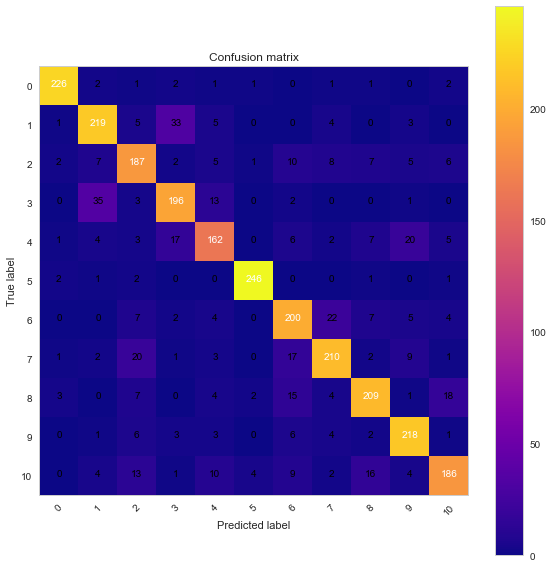

In [119]:
# One-hot encode because of NDA
encoder = LabelEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)
encoded_y_test = encoder.transform(y_test)
encoded_y_pred = encoder.transform(y_pred)

# Print scores and confusion matrix
print(classification_report(encoded_y_test, encoded_y_pred))
cnf_matrix = confusion_matrix(encoded_y_test, encoded_y_pred)

sns.set_style("whitegrid", {'axes.grid' : False})
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=np.unique(encoded_y))

This shows that we're getting very good results, but we can't see the between-category differences because the diagonal is washing out the effect...

Confusion matrix (no normalization)


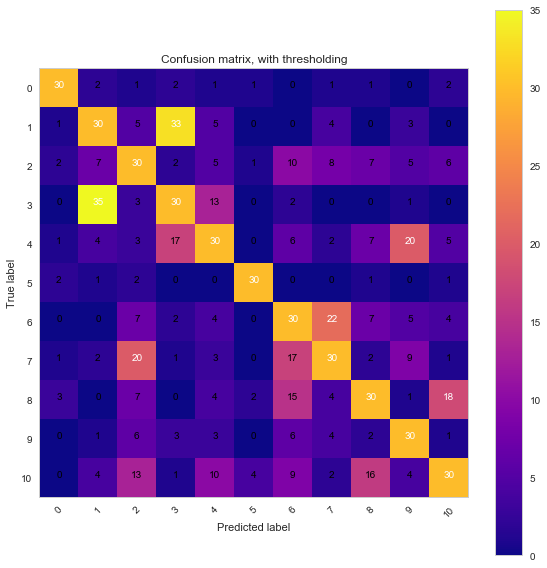

In [116]:
# Threshold the diagonal so we can see the errors better:
cnf_matrix = confusion_matrix(encoded_y_test, encoded_y_pred)
threshCM = cnf_matrix

for i in range(0, 11):
    threshCM[i][i] = 30

plt.figure(figsize=(8,8))
plot_confusion_matrix(threshCM, classes=np.unique(encoded_y),
                      title='Confusion matrix, with thresholding')